# CNN from scratch

In [1]:
import torch
import numpy as np
import os
import requests, zipfile, io
from torchvision import transforms, models
from torchsampler import ImbalancedDatasetSampler
from torchvision import datasets
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import splitfolders
from typing import Any


## Data preparation

### Download

In [2]:
URL = 'https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip'
DATA_FOLDER = 'data'

if not(os.path.exists(DATA_FOLDER)):
    print(f"Downloading data to folder {DATA_FOLDER}")
    response = requests.get(URL)
    zipped_data = zipfile.ZipFile(io.BytesIO(response.content))
    zipped_data.extractall(DATA_FOLDER)
    print("Download complete and data extracted")
else:
    print(f"Data already download, check path {DATA_FOLDER}")

Data already download, check path data


### Splitting data 

In [2]:
BATCH_SIZE = 32
NUM_WORKERS = 4
DATA_LOCATION = "data/landmark_images/"
SPLITS_RATIO = (.8, .2)
SEED = 1337

split = splitfolders.ratio(os.path.join(DATA_LOCATION, 'train'),
        output = os.path.join(DATA_LOCATION, 'split'),
        seed = SEED,
        ratio = SPLITS_RATIO,
        group_prefix=None
        )

train_dataset_path = os.path.join(DATA_LOCATION, 'split', 'train')
validation_dataset_path = os.path.join(DATA_LOCATION, 'split', 'val')
test_dataset_path = os.path.join(DATA_LOCATION, 'test')

Copying files: 4996 files [00:05, 989.50 files/s] 


### Create DataLoaders

#### Transform Data

In [3]:
train_transform = transforms.Compose([
                    transforms.Resize([224,224]),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomHorizontalFlip(), 
                    transforms.ColorJitter(brightness=0.3,
                                            contrast=0.2,
                                            saturation=0.3,
                                            hue=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

valid_and_test_transform = transforms.Compose([
                    transforms.Resize([224,224]),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = datasets.ImageFolder(train_dataset_path, transform=train_transform)
validation_data = datasets.ImageFolder(validation_dataset_path, transform=valid_and_test_transform)
test_data = datasets.ImageFolder(test_dataset_path, transform=valid_and_test_transform)


### Data loaders

In [4]:
train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size = BATCH_SIZE,
            sampler = ImbalancedDatasetSampler(train_data),
            num_workers = NUM_WORKERS,
)

validation_loader = torch.utils.data.DataLoader(
                validation_data,
                batch_size = BATCH_SIZE,
                shuffle = True
)

test_loader = torch.utils.data.DataLoader(
                test_data,
                batch_size = BATCH_SIZE
)

loaders_dict = {'train': train_loader, 'validation': validation_loader, 'test': test_loader}

In [6]:
print(f'Number of images for training is {len(train_data)}, for validation is {len(validation_data)}, and for testing is {len(test_data)}')
print(f'Total batches for training are {len(train_loader)}, for validation {len(validation_loader)} and for testing {len(test_loader)}')

Number of images for training is 3996, for validation is 1000, and for testing is 1250
Total batches for training are 134, for validation 34 and for testing 42


In [5]:
classes = [str(x)[3:].replace("_", " ") for x in train_data.classes]
classes

['Haleakala National Park',
 'Mount Rainier National Park',
 'Ljubljana Castle',
 'Dead Sea',
 'Wroclaws Dwarves',
 'London Olympic Stadium',
 'Niagara Falls',
 'Stonehenge',
 'Grand Canyon',
 'Golden Gate Bridge',
 'Edinburgh Castle',
 'Mount Rushmore National Memorial',
 'Kantanagar Temple',
 'Yellowstone National Park',
 'Terminal Tower',
 'Central Park',
 'Eiffel Tower',
 'Changdeokgung',
 'Delicate Arch',
 'Vienna City Hall',
 'Matterhorn',
 'Taj Mahal',
 'Moscow Raceway',
 'Externsteine',
 'Soreq Cave',
 'Banff National Park',
 'Pont du Gard',
 'Seattle Japanese Garden',
 'Sydney Harbour Bridge',
 'Petronas Towers',
 'Brooklyn Bridge',
 'Washington Monument',
 'Hanging Temple',
 'Sydney Opera House',
 'Great Barrier Reef',
 'Monumento a la Revolucion',
 'Badlands National Park',
 'Atomium',
 'Forth Bridge',
 'Gateway of India',
 'Stockholm City Hall',
 'Machu Picchu',
 'Death Valley National Park',
 'Gullfoss Falls',
 'Trevi Fountain',
 'Temple of Heaven',
 'Great Wall of China',

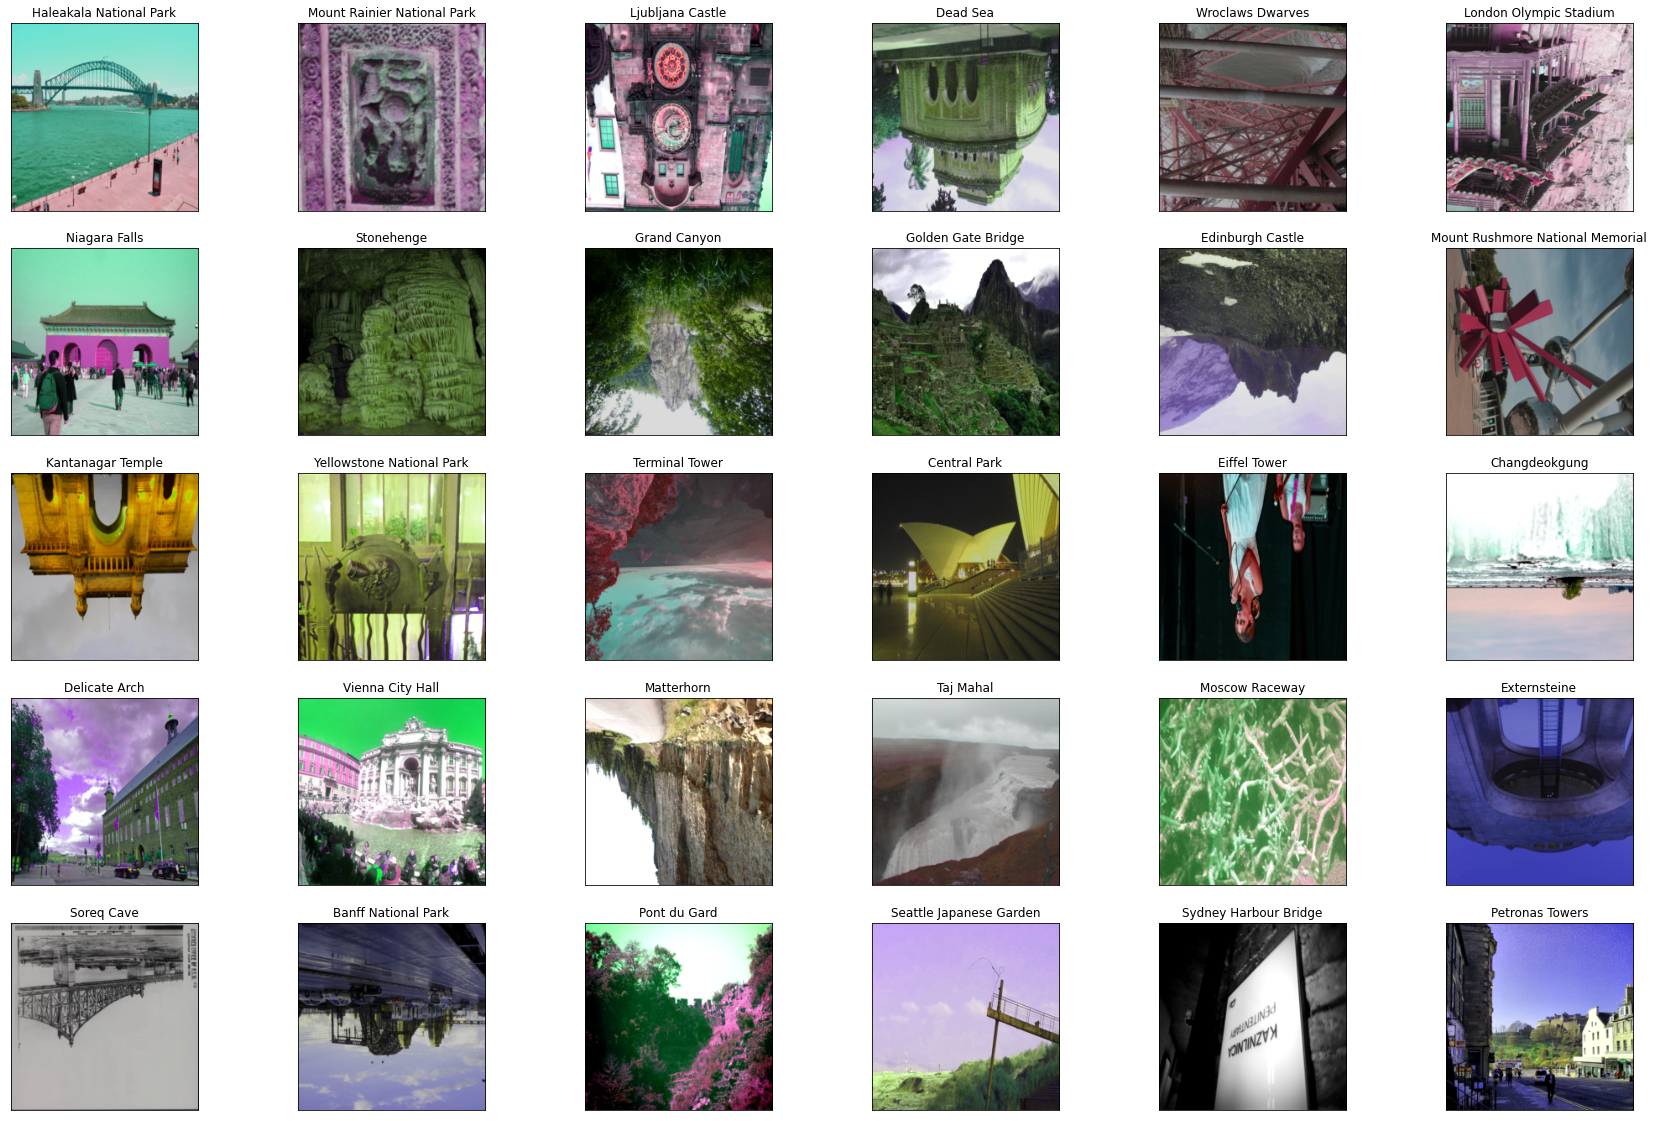

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_img(img):
    img = img /2 +0.5
    plt.imshow(np.transpose(img, (1,2,0)))

    
images, labels = next(iter(train_loader))
images = images.numpy()
    
fig = plt.figure(figsize=(30,20))

#Showing first 30 images
for idx, image in enumerate(images[0:30]):
    ax = fig.add_subplot(5,6, idx+1, xticks=[],yticks=[])
    show_img(images[idx])
    ax.set_title(classes[idx], wrap=True)
    

### Model Architecture

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"We will train on {device}")

We will train on cuda


In [7]:
## Loss function

def get_loss_function():
    return nn.CrossEntropyLoss()

def get_optimizer(model, lr, momentum):
    return optim.SGD(model.parameters(), lr = lr, momentum = momentum)

def get_scheduler(optimizer):
    return optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 10)

In [11]:
cnn_model = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(16, 32, 3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(32, 64, 3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Flatten(),
                        nn.Dropout(0.25),
                        nn.Linear(64*28*28, 1024),
                        nn.LeakyReLU(),
                        nn.Dropout(0.25),
                        nn.Linear(1024, 512),
                        nn.LeakyReLU(),
                        nn.Dropout(0.25),
                        nn.Linear(512, len(classes))
)

In [12]:
cnn_model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.25, inplace=False)
  (11): Linear(in_features=50176, out_features=1024, bias=True)
  (12): LeakyReLU(negative_slope=0.01)
  (13): Dropout(p=0.25, inplace=False)
  (14): Linear(in_features=1024, out_features=512, bias=True)
  (15): LeakyReLU(negative_slope=0.01)
  (16): Dropout(p=0.25, inplace=False)
  (17): Linear(in_features=512, out_features=50, bias=True)
)

In [13]:
summary(cnn_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Flatten-10                [-1, 50176]               0
          Dropout-11                [-1, 50176]               0
           Linear-12                 [-1, 1024]      51,381,248
        LeakyReLU-13                 [-1, 1024]               0
          Dropout-14                 [-

In [15]:
def train(n_epochs: int, loaders: dict, model: Any, optimizer: Any, scheduler: Any, loss_function: Any, use_cuda: bool, save_path: str) -> None:
    
    lowest_validation_loss = np.Inf

    print("Training on: ", device," -> ", torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('\tAllocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('\tCached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

    for epoch in range(1, n_epochs +1):
        train_loss, valid_loss = 0.0, 0.0

        ##Train model
        #Set model to train
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            #Move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

                optimizer.zero_grad() #Clearing gradient
                output = model(data)
                loss = loss_function(output, target)
                loss.backward()
                optimizer.step()
                train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        print(f"Learning rate is now {optimizer.param_groups[0]['lr']}")

        #Evaluating model
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['validation']):
                #Move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                output = model(data)
                loss = loss_function(output, target)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
        
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(validation_loader)

        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

        if (valid_loss <= lowest_validation_loss):
            print(f'Validation loss decreased ({lowest_validation_loss:.6f} --> {valid_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), save_path)
            lowest_validation_loss = valid_loss
        
        scheduler.step(lowest_validation_loss)
    return model

#### Let's train!

In [15]:
optimizer = get_optimizer(cnn_model, lr=0.01, momentum=0.9)

torch.cuda.empty_cache() 

trained_model_scratch = train(60,
                        loaders_dict, 
                        cnn_model, 
                        optimizer,
                        get_scheduler(optimizer),
                        get_loss_function(), 
                        True if device == "cuda" else False,
                        'cnn_scratch.pt')

Training on:  cuda  ->  NVIDIA GeForce RTX 2070 with Max-Q Design
Memory Usage:
	Allocated: 0.2 GB
	Cached:    0.2 GB
Learning rate is now 0.01
Epoch: 1 	Training Loss: 0.029164 	Validation Loss: 0.114356
Validation loss decreased (inf --> 0.114356).  Saving model ...
Learning rate is now 0.01
Epoch: 2 	Training Loss: 0.028772 	Validation Loss: 0.111808
Validation loss decreased (0.114356 --> 0.111808).  Saving model ...
Learning rate is now 0.01
Epoch: 3 	Training Loss: 0.028251 	Validation Loss: 0.110182
Validation loss decreased (0.111808 --> 0.110182).  Saving model ...
Learning rate is now 0.01
Epoch: 4 	Training Loss: 0.027336 	Validation Loss: 0.108742
Validation loss decreased (0.110182 --> 0.108742).  Saving model ...
Learning rate is now 0.01
Epoch: 5 	Training Loss: 0.026933 	Validation Loss: 0.104713
Validation loss decreased (0.108742 --> 0.104713).  Saving model ...
Learning rate is now 0.01
Epoch: 6 	Training Loss: 0.026216 	Validation Loss: 0.106243
Learning rate is now

### Let's test the model on the test data set

In [18]:
def test(loaders: dict, model: Any, loss_function: Any) -> None:

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if device == "cuda":
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = loss_function(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [17]:
trained_model_scratch.load_state_dict(torch.load('cnn_scratch.pt'))
test(loaders_dict, trained_model_scratch, get_loss_function())

Test Loss: 2.955963


Test Accuracy: 27% (345/1250)


# Transfer learning

In [7]:
from torchvision.models import resnet50, ResNet50_Weights
model_transfer = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

In [9]:
for parameters in model_transfer.parameters():
    parameters.requires_grad = False

model_transfer.fc = nn.Sequential(nn.Linear(2048, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.15),
                                    nn.Linear(512, 50),
)

model_transfer.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
optimizer = get_optimizer(model_transfer, lr=0.01, momentum=0.9)

In [16]:
trained_model_transfer_learning = train(50,
                        loaders_dict, 
                        model_transfer, 
                        optimizer,
                        get_scheduler(optimizer),
                        get_loss_function(), 
                        True if device == "cuda" else False,
                        'cnn_transfer_learning.pt')

Training on:  cuda  ->  NVIDIA GeForce RTX 2070 with Max-Q Design
Memory Usage:
	Allocated: 0.1 GB
	Cached:    0.1 GB
Learning rate is now 0.01
Epoch: 1 	Training Loss: 0.024069 	Validation Loss: 0.066109
Validation loss decreased (inf --> 0.066109).  Saving model ...
Learning rate is now 0.01
Epoch: 2 	Training Loss: 0.015377 	Validation Loss: 0.049706
Validation loss decreased (0.066109 --> 0.049706).  Saving model ...
Learning rate is now 0.01
Epoch: 3 	Training Loss: 0.012620 	Validation Loss: 0.043488
Validation loss decreased (0.049706 --> 0.043488).  Saving model ...
Learning rate is now 0.01
Epoch: 4 	Training Loss: 0.011214 	Validation Loss: 0.040328
Validation loss decreased (0.043488 --> 0.040328).  Saving model ...
Learning rate is now 0.01
Epoch: 5 	Training Loss: 0.010491 	Validation Loss: 0.037497
Validation loss decreased (0.040328 --> 0.037497).  Saving model ...
Learning rate is now 0.01
Epoch: 6 	Training Loss: 0.009851 	Validation Loss: 0.036881
Validation loss decr

In [10]:
model_transfer.load_state_dict(torch.load('cnn_transfer_learning.pt'))

<All keys matched successfully>

In [19]:
test(loaders_dict, model_transfer, get_loss_function())

Test Loss: 0.884768


Test Accuracy: 77% (970/1250)


# Inference Time

In [10]:
model_transfer.load_state_dict(torch.load('cnn_transfer_learning.pt'))
model_transfer.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
from PIL import Image

def predict_landmarks(img_path, k):
    top_k_classes = []
    img = Image.open(img_path)
    convert_to_tensor = transforms.Compose([transforms.Resize([224,224]),
                                     transforms.ToTensor()])
    img = convert_to_tensor(img)
    img.unsqueeze_(0)
    
    img = img.to(device)
        
    model_transfer.eval()
    output = model_transfer(img)
    value, index_class = output.topk(k)

    for index in index_class[0].tolist():
        top_k_classes.append(classes[index])
    
    model_transfer.train()
        
    return value[0].tolist(), top_k_classes
    


# test on a sample image
predict_landmarks('data/landmark_images/test/09.Golden_Gate_Bridge/1bc7a7f05288153b.jpg', 5)

([16.725576400756836,
  10.52921199798584,
  10.092767715454102,
  8.731866836547852,
  7.1621599197387695],
 ['Golden Gate Bridge',
  'Forth Bridge',
  'Brooklyn Bridge',
  'Dead Sea',
  'Niagara Falls'])